In [24]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# plotting the car
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import scipy.misc
from scipy import ndimage

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

%matplotlib inline

# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

In [25]:
X = cas.MX.sym('X')
Y = cas.MX.sym('Y')
Phi = cas.MX.sym('Phi')
Delta = cas.MX.sym('Delta')
V = cas.MX.sym('V')
s = cas.MX.sym('s')

delta_u = cas.MX.sym('delta_u')
v_u = cas.MX.sym('v_u')
x = cas.vertcat(X, Y, Phi, Delta, V, s)
u = cas.vertcat(delta_u, v_u)

L = 1.0
ode = cas.vertcat(V * cas.cos(Phi),
                V * cas.sin(Phi),
                V * cas.tan(Delta) / L,
                delta_u,
                v_u,
                V)

f = cas.Function('f',[x,u],[ode],['x','u'],['ode'])

#  States

$\vec{x}$ = $[x, y, \phi, \delta, V, s]^T$

$\vec{u}$ = $[\delta^u, v^u]^T$

# Discrete (integrated) dynamics $\vec{x}_{t+1} = F(\vec{x}_{t}, \vec{u}_{t})$

In [26]:
T = 3 #numbr of time horizons
dt = 0.1
N = int(T/dt) #Number of control intervals
intg_options = {}
intg_options['tf'] = dt # from dt
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 6  #from 4

dae = {}  #What's a DAE?
dae['x'] = x
dae['p'] = u
dae['ode'] = f(x,u)
intg = cas.integrator('intg','rk', dae, intg_options)
res = intg(x0=x,p=u)
x_next = res['xf']
F = cas.Function('F',[x,u],[x_next],['x','u'],['x_next'])

# Car class (for plotting)

In [27]:
class Car:
    def __init__(self):
        self.L = 1.0 # m
        
    def get_frame(self, x, ax=None, amb=False, min_distance=-1, circle=False ):
    
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))
        else:
            fig = ax.get_figure()
            
            
        X, Y, Phi, Delta, V, S = x.flatten()
        if not amb:
            arr_img = plt.imread('red_car.png', format='png')
        else:
            arr_img = plt.imread('ambulance.png', format='png')
        degree = np.rad2deg(Phi)
        xy = (X, Y)
        rotated_img = ndimage.rotate(arr_img, degree)
        ax.axis('square')
        window_width = 12
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        if circle:
            circle_patch = patches.Circle(xy, radius=min_distance/2)
            ax.add_patch(circle_patch)
        else:
            if not amb:
                imagebox = OffsetImage(rotated_img, zoom=self.L * 1/(2*window_width)) #this zoom is to scale L=1
            else:
                imagebox = OffsetImage(rotated_img, zoom=1/3*self.L * 1/(2*window_width)) #this zoom is to scale L=1            
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, (X, Y),frameon=False)
            ax.add_artist(ab)        

        return fig, ax        

# Parameterization of Desired Trajectory ($\vec{x}_d = f_d(s)$)

In [28]:
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)

fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

### Solve it centrally just to warm start the solution

In [29]:
#Globally true information

min_dist = 2 * (2 * .5**2)**.5

# Initial Conditions
x0 = np.array([2*min_dist, .6*min_dist, 0, 0, 1.0, 0]).T
x0_2 = np.array([2*min_dist,-.6*min_dist, .0, 0, 1.0,0]).T
x0_amb = np.array([0, 0.0, 0, 0, 2.5,0]).T

n_cars = 3

In [36]:
optional_suffix = ""
folder = "results/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)



# Generating Cost Matrices
q_lon, q_lat, q_phi, q_v, = 1., 5.0, 5.0, -.1,  #State costs
r_delta, r_vdot = 10.0, 10.0  #Control input costs

Q_k = np.eye(6)
Q_k[0,0] = q_lon
Q_k[1,1] = q_lat
Q_k[2,2] = q_phi
Q_k[3,3] = 0
Q_k[4,4] = q_v
Q_k[5,5] = q_lon
# C[6,6] = r_delta
# C[7,7] = r_vdot
Q_k[0,5] = -q_lon
Q_k[5,0] = -q_lon
R_k = np.eye(2)

opti = cas.Opti()
n_ctrl = 2
n_state = 6


#Variables
x_opt = opti.variable(n_state, N+1) # initialize X for each car that we will optimize
x2_opt = opti.variable(n_state, N+1)
xamb_opt = opti.variable(n_state, N+1)

u_opt = opti.variable(n_ctrl, N)
u2_opt = opti.variable(n_ctrl, N)
uamb_opt = opti.variable(n_ctrl, N)

p = opti.parameter(n_state, 1) #this will be the initial state
p2 = opti.parameter(n_state, 1)
pamb = opti.parameter(n_state, 1)


x_desired = opti.variable(3, N+1)
x2_desired = opti.variable(3, N+1)
xamb_desired = opti.variable(3, N+1)

#### Costs

car1_u_delta_cost = 10 * cas.sumsqr(u_opt[0,:])
car1_u_v_cost = 1 * cas.sumsqr(u_opt[1,:])

car1_lat_cost = np.sum([(-cas.sin(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.cos(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)])
car1_lon_cost = np.sum([(cas.cos(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.sin(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)]) 
car1_phi_cost = cas.sumsqr(x_desired[2,:]-x_opt[2,:]) 
car1_v_cost = cas.sumsqr(x_opt[4,:])   
phid_1 = x_opt[4,:] * cas.tan(x_opt[3,:]) / L
phid1_cost = cas.sumsqr(phid_1)

k_lat1 = 10
k_lon1 = .1
k_phi1 = 10.0
k_phid1 = 1.0

car1_costs = (car1_u_delta_cost + car1_u_v_cost + 
    k_lat1*car1_lat_cost + k_lon1*car1_lon_cost + k_phi1 * car1_phi_cost + 
              k_phid1 * phid1_cost +
             0.001*q_v*car1_v_cost)


car2_u_delta_cost = 10 * cas.sumsqr(u2_opt[0,:])
car2_u_v_cost = 1 * cas.sumsqr(u2_opt[1,:])

car2_lat_cost = np.sum([(-cas.sin(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.cos(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)])
car2_lon_cost = np.sum([(cas.cos(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.sin(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)]) 
car2_phi_cost = cas.sumsqr(x2_desired[2,:]-x2_opt[2,:]) 
car2_v_cost = cas.sumsqr(x2_opt[4,:])   
phid_2 = x2_opt[4,:] * cas.tan(x2_opt[3,:]) / L
phid2_cost =cas.sumsqr(phid_2)    


k_lat2 = 10
k_lon2 = .10    
k_phi2 = 10.0
k_phid2 = 1.0

car2_costs = (car2_u_delta_cost + car2_u_v_cost + 
    k_lat2*car2_lat_cost + k_lon2*car2_lon_cost + k_phi2*car2_phi_cost + 
              k_phid2*phid2_cost + 0.001*q_v*car2_v_cost)    

R_k = 1*R_k

#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt[:,k]) @ R_k @ uamb_opt[:,k] for k in range(N)])

amb_u_delta_cost = 10 * cas.sumsqr(uamb_opt[0,:])
amb_u_v_cost = 0.1 * cas.sumsqr(uamb_opt[1,:])

amb_lat_cost = np.sum([(-cas.sin(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.cos(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)])


amb_lon_cost = np.sum([(cas.cos(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.sin(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)]) 

amb_phi_cost = cas.sumsqr(xamb_desired[2,:]-xamb_opt[2,:]) 
amb_v_cost = cas.sumsqr(xamb_opt[4,:])  

phid_amb= xamb_opt[4,:] * cas.tan(xamb_opt[3,:]) / L
phidamb_cost =cas.sumsqr(phid_amb)   

k_latamb = 10
k_lonamb = 1.0        
k_phiamb = 10.0
k_phidamb = 1.0
amb_costs = (amb_u_delta_cost + amb_u_v_cost + 
             k_latamb*amb_lat_cost + k_lonamb*amb_lon_cost + k_phiamb*amb_phi_cost + 
             k_phidamb * phidamb_cost + q_v*amb_v_cost
            )


theta_1 = np.pi/4
theta_2 = np.pi/4
theta_amb = 0
######## optimization  ##################################
opti.minimize(np.cos(theta_amb)*amb_costs + np.sin(theta_amb)*(car1_costs + car2_costs) + 
              (np.cos(theta_1)*car1_costs + np.sin(theta_1)*amb_costs) + 
              (np.cos(theta_2)*car2_costs + np.sin(theta_2)*amb_costs)
             )    
##########################################################
#constraints

for k in range(N):
    opti.subject_to( x_opt[:, k+1] == F(x_opt[:, k], u_opt[:, k]))

for k in range(N+1):
    opti.subject_to( x_desired[:, k] == fd(x_opt[-1, k]) ) #This should be the trajectory dynamic constraint        


opti.subject_to(opti.bounded(-np.pi/6, u_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, u_opt[1,:], 4)) # 0-60 around 4 m/s^2
v_max = 10
opti.subject_to(opti.bounded(0, x_opt[4,:],v_max))    
opti.subject_to(x_opt[:,0] == p)

#Just repeat constraints for x2
for k in range(N):
    opti.subject_to( x2_opt[:, k+1] == F(x2_opt[:, k], u2_opt[:, k]))
for k in range(N+1):
    opti.subject_to( x2_desired[:, k] == fd(x2_opt[-1, k]) ) #This should be the trajectory dynamic constraint             


opti.subject_to(opti.bounded(-np.pi/6, u2_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, u2_opt[1,:], 4))
v_max = 10
opti.subject_to(opti.bounded(0, x2_opt[4,:],v_max))    
opti.subject_to(x2_opt[:,0] == p2)

#ambulance
for k in range(N):
    opti.subject_to( xamb_opt[:, k+1] == F(xamb_opt[:, k], uamb_opt[:, k]))
for k in range(N+1):
    opti.subject_to( xamb_desired[:, k] == fd(xamb_opt[-1, k]) ) #This should be the trajectory dynamic constraint             


opti.subject_to(opti.bounded(-np.pi/6, uamb_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, uamb_opt[1,:], 4))
v_max = 20
opti.subject_to(opti.bounded(0, xamb_opt[4,:],v_max))    
opti.subject_to(xamb_opt[:,0] == pamb)    

#     min_dist = 0.6
for k in range(N+1):
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]) > min_dist**2 )
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )
    opti.subject_to( cas.sumsqr(x2_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )

# constraints to help out
opti.subject_to( opti.bounded(-1, x_opt[0,:], 30) )
opti.subject_to( opti.bounded(-1, x2_opt[0,:], 30) )
opti.subject_to( opti.bounded(-1, xamb_opt[0,:], 30) )
opti.subject_to( opti.bounded(-10, x_opt[1,:], 10) )
opti.subject_to( opti.bounded(-10, x2_opt[1,:], 10) )
opti.subject_to( opti.bounded(-10, xamb_opt[1,:], 10) )

# constrain crazy turns
opti.subject_to( opti.bounded(-np.pi/2, x_opt[2,:], np.pi/2) )
opti.subject_to( opti.bounded(-np.pi/2, x2_opt[2,:], np.pi/2) )
opti.subject_to( opti.bounded(-np.pi/2, xamb_opt[2,:], np.pi/2) )    

# constrain the lane deviations to prevent wacky solutions
#     opti.subject_to( opti.bounded(-5, x_opt[0,:] - x_desired[0,:], 5))
#     opti.subject_to( opti.bounded(-5, x2_opt[0,:] - x2_desired[0,:], 5))
opti.subject_to( opti.bounded(-5, xamb_opt[0,:] - xamb_desired[0,:], 5))
opti.subject_to( opti.bounded(-10, x_opt[1,:] - x_desired[1,:], 10))
opti.subject_to( opti.bounded(-10, x2_opt[1,:] - x2_desired[1,:], 10))
opti.subject_to( opti.bounded(-10, xamb_opt[1,:] - xamb_desired[1,:], 10))


opti.solver('ipopt',{'warn_initial_bounds':True},{'print_level':0})

opti.set_value(p,x0)
opti.set_value(p2,x0_2)
opti.set_value(pamb,x0_amb) 

results/20200207-145203/


In [37]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.79ms (143.71us)  12.70ms (142.73us)        89
       nlp_g  | 155.51ms (  1.75ms) 153.97ms (  1.73ms)        89
    nlp_grad  |   9.25ms (  9.25ms)   9.16ms (  9.16ms)         1
  nlp_grad_f  |  23.35ms (268.44us)  23.11ms (265.63us)        87
  nlp_hess_l  |   4.25 s ( 50.64ms)   4.21 s ( 50.11ms)        84
   nlp_jac_g  |   1.66 s ( 18.92ms)   1.65 s ( 18.73ms)        88
       total  |   6.67 s (  6.67 s)   6.60 s (  6.60 s)         1


In [38]:
x_warm = sol.value(x_opt)
u_warm = sol.value(u_opt)
x2_warm = sol.value(x2_opt)
u2_warm = sol.value(u2_opt)
xamb_warm = sol.value(xamb_opt)
uamb_warm = sol.value(uamb_opt)

x_des = sol.value(x_desired)
x2_des = sol.value(x2_desired)

In [39]:
ego_car = Car()
for k in range(N+1):

    fig, ax = ego_car.get_frame(x_warm[:,k],None,False,min_dist,True)
    fig, ax = ego_car.get_frame(x2_warm[:,k], ax,False,min_dist,True)
    fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, False,min_dist,True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
    ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     

In [40]:
vid_fname = folder + 'car.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200207-145203/car.mp4


In [41]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

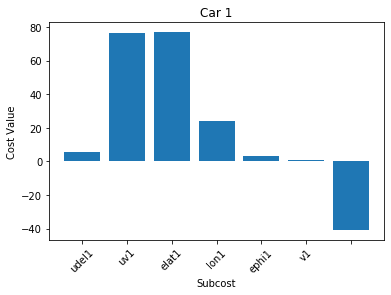

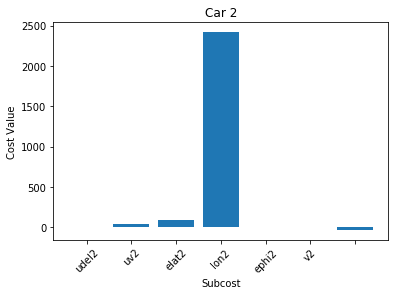

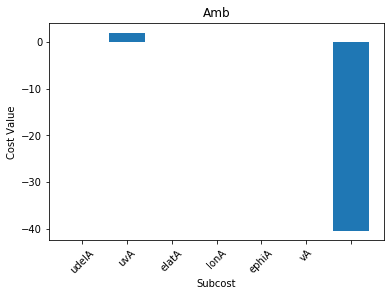

Text(0, 0.5, 'Cost Value')

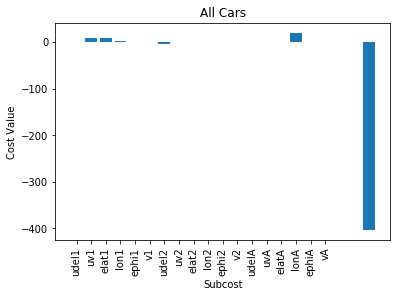

In [42]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, k_lat1*car1_lat_cost, k_lon1*car1_lon_cost, k_phi1*car1_phi_cost, k_phid1*phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, k_phi2*car2_phi_cost, k_phid2*phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost,k_phiamb*amb_phi_cost, k_phidamb*phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

## Optimization

In [13]:
## Best response for vehicle 1
opti = cas.Opti()
n_ctrl = 2
n_state = 6

#Variables
x_opt = opti.variable(n_state, N+1) # initialize X for each car that we will optimize
u_opt = opti.variable(n_ctrl, N)



# These are now parameters!!
x2_opt = opti.parameter(n_state, N+1)
xamb_opt = opti.parameter(n_state, N+1)
u2_opt = opti.parameter(n_ctrl, N)
uamb_opt = opti.parameter(n_ctrl, N)

p = opti.parameter(n_state, 1) #this will be the initial state
p2 = opti.parameter(n_state, 1)
pamb = opti.parameter(n_state, 1)


x_desired = opti.variable(3, N+1)
x2_desired = opti.variable(3, N+1)
xamb_desired = opti.variable(3, N+1)

#### Costs

car1_u_delta_cost = 10 * cas.sumsqr(u_opt[0,:])
car1_u_v_cost = 1 * cas.sumsqr(u_opt[1,:])

car1_lat_cost = np.sum([(-cas.sin(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.cos(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)])
car1_lon_cost = np.sum([(cas.cos(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.sin(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)]) 
car1_phi_cost = cas.sumsqr(x_desired[2,:]-x_opt[2,:]) 
car1_v_cost = cas.sumsqr(x_opt[4,:])   
phid_1 = x_opt[4,:] * cas.tan(x_opt[3,:]) / L
phid1_cost = cas.sumsqr(phid_1)

k_lat1 = 10
k_lon1 = 10
k_phid1 = 1.0

car1_costs = (car1_u_delta_cost + car1_u_v_cost + 
    k_lat1*car1_lat_cost + k_lon1*car1_lon_cost + car1_phi_cost + 
              k_phid1 * phid1_cost +
             q_v*car1_v_cost)


car2_u_delta_cost = 10 * cas.sumsqr(u2_opt[0,:])
car2_u_v_cost = 1 * cas.sumsqr(u2_opt[1,:])

car2_lat_cost = np.sum([(-cas.sin(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.cos(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)])
car2_lon_cost = np.sum([(cas.cos(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.sin(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)]) 
car2_phi_cost = cas.sumsqr(x2_desired[2,:]-x2_opt[2,:]) 
car2_v_cost = cas.sumsqr(x2_opt[4,:])   
phid_2 = x2_opt[4,:] * cas.tan(x2_opt[3,:]) / L
phid2_cost =cas.sumsqr(phid_2)    


k_lat2 = 10
k_lon2 = 10    
k_phid2 = 1.0

car2_costs = (car2_u_delta_cost + car2_u_v_cost + 
    k_lat2*car2_lat_cost + k_lon2*car2_lon_cost + car2_phi_cost + 
              k_phid2*phid2_cost + q_v*car2_v_cost)    

R_k = 1*R_k

#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt[:,k]) @ R_k @ uamb_opt[:,k] for k in range(N)])

amb_u_delta_cost = 10 * cas.sumsqr(uamb_opt[0,:])
amb_u_v_cost = 0.1 * cas.sumsqr(uamb_opt[1,:])

amb_lat_cost = np.sum([(-cas.sin(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.cos(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)])


amb_lon_cost = np.sum([(cas.cos(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.sin(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)]) 

amb_phi_cost = cas.sumsqr(xamb_desired[2,:]-xamb_opt[2,:]) 
amb_v_cost = cas.sumsqr(xamb_opt[4,:])  

phid_amb= xamb_opt[4,:] * cas.tan(xamb_opt[3,:]) / L
phidamb_cost =cas.sumsqr(phid_amb)   

k_latamb = 10
k_lonamb = 10        
k_phidamb = 1.0
amb_costs = (amb_u_delta_cost + amb_u_v_cost + 
             k_latamb*amb_lat_cost + k_lonamb*amb_lon_cost + amb_phi_cost + 
             k_phidamb * phidamb_cost + q_v*amb_v_cost
            )


theta_1 = np.pi/4
theta_2 = np.pi/4
theta_amb = 0
######## optimization  ##################################
opti.minimize(np.cos(theta_1)*car1_costs + np.sin(theta_1)*amb_costs)    
##########################################################



#constraints

for k in range(N):
    opti.subject_to( x_opt[:, k+1] == F(x_opt[:, k], u_opt[:, k]))

for k in range(N+1):
    opti.subject_to( x_desired[:, k] == fd(x_opt[-1, k]) ) #This should be the trajectory dynamic constraint        


opti.subject_to(opti.bounded(-np.pi/6, u_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, u_opt[1,:], 4)) # 0-60 around 4 m/s^2
v_max = 10
opti.subject_to(opti.bounded(0, x_opt[4,:],v_max))    
opti.subject_to(x_opt[:,0] == p)

#     min_dist = 0.6
for k in range(N+1):
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]) > min_dist**2 )
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )

# constraints to help out
opti.subject_to( opti.bounded(-1, x_opt[0,:], 30) )
opti.subject_to( opti.bounded(-10, x_opt[1,:], 10) )
opti.subject_to( opti.bounded(-np.pi/2, x_opt[2,:], np.pi/4) )


# constrain the lane deviations to prevent wacky solutions
#     opti.subject_to( opti.bounded(-5, x_opt[0,:] - x_desired[0,:], 5))
#     opti.subject_to( opti.bounded(-5, x2_opt[0,:] - x2_desired[0,:], 5))
opti.subject_to( opti.bounded(-5, xamb_opt[0,:] - xamb_desired[0,:], 5))
opti.subject_to( opti.bounded(-10, x_opt[1,:] - x_desired[1,:], 10))

opti.solver('ipopt',{'warn_initial_bounds':True},{'print_level':0})

opti.set_value(p,x0)
opti.set_value(p2,x0_2)
opti.set_value(pamb,x0_amb)     




In [14]:
opti2 = cas.Opti()
n_ctrl = 2
n_state = 6

#Variables
x2_opt2 = opti2.variable(n_state, N+1)
u2_opt2 = opti2.variable(n_ctrl, N)

### Agent 2 has these as parameters!!!
x_opt2 = opti2.parameter(n_state, N+1) # initialize X for each car that we will opti2mize
xamb_opt2 = opti2.parameter(n_state, N+1)
u_opt2 = opti2.parameter(n_ctrl, N)
uamb_opt2 = opti2.parameter(n_ctrl, N)

p_2 = opti2.parameter(n_state, 1) #this will be the initial state
p2_2 = opti2.parameter(n_state, 1)
pamb_2 = opti2.parameter(n_state, 1)

x_desired_2 = opti2.variable(3, N+1)
x2_desired_2 = opti2.variable(3, N+1)
xamb_desired_2 = opti2.variable(3, N+1)

#### Costs
car1_u_delta_cost_2 = 10 * cas.sumsqr(u_opt2[0,:])
car1_u_v_cost_2 = 1 * cas.sumsqr(u_opt2[1,:])
car1_lat_cost_2 = np.sum([(-cas.sin(x_desired_2[2,k]) * (x_opt2[0,k]-x_desired_2[0,k]) + 
            cas.cos(x_desired_2[2,k]) * (x_opt2[1,k]-x_desired_2[1,k]))**2
           for k in range(N+1)])
car1_lon_cost_2 = np.sum([(cas.cos(x_desired_2[2,k]) * (x_opt2[0,k]-x_desired_2[0,k]) + 
            cas.sin(x_desired_2[2,k]) * (x_opt2[1,k]-x_desired_2[1,k]))**2
           for k in range(N+1)]) 
car1_phi_cost_2 = cas.sumsqr(x_desired_2[2,:]-x_opt2[2,:]) 
car1_v_cost_2 = cas.sumsqr(x_opt2[4,:])   
phid_1_2 = x_opt2[4,:] * cas.tan(x_opt2[3,:]) / L
phid1_cost_2 = cas.sumsqr(phid_1_2)

k_lat1_2 = 10
k_lon1_2 = 10
k_phid1_2 = 1.0

car1_costs_2 = (car1_u_delta_cost_2 + car1_u_v_cost_2 + 
    k_lat1_2*car1_lat_cost_2 + k_lon1_2*car1_lon_cost_2 + car1_phi_cost_2 + 
              k_phid1_2 * phid1_cost_2 +
             q_v*car1_v_cost_2)


car2_u_delta_cost_2 = 10 * cas.sumsqr(u2_opt2[0,:])
car2_u_v_cost_2 = 1 * cas.sumsqr(u2_opt2[1,:])
car2_lat_cost_2 = np.sum([(-cas.sin(x2_desired_2[2,k]) * (x2_opt2[0,k]-x2_desired_2[0,k]) + 
            cas.cos(x2_desired_2[2,k]) * (x2_opt2[1,k]-x2_desired_2[1,k]))**2
           for k in range(N+1)])
car2_lon_cost_2 = np.sum([(cas.cos(x2_desired_2[2,k]) * (x2_opt2[0,k]-x2_desired_2[0,k]) + 
            cas.sin(x2_desired_2[2,k]) * (x2_opt2[1,k]-x2_desired_2[1,k]))**2
           for k in range(N+1)]) 
car2_phi_cost_2 = cas.sumsqr(x2_desired_2[2,:]-x2_opt2[2,:]) 
car2_v_cost_2 = cas.sumsqr(x2_opt2[4,:])   
phid_2_2 = x2_opt2[4,:] * cas.tan(x2_opt2[3,:]) / L
phid2_cost_2 =cas.sumsqr(phid_2_2)    

k_lat2_2 = 10
k_lon2_2 = 10    
k_phid2_2 = 1.0

car2_costs_2 = (car2_u_delta_cost_2 + car2_u_v_cost_2 + 
    k_lat2*car2_lat_cost_2 + k_lon2*car2_lon_cost_2 + car2_phi_cost_2 + 
              k_phid2_2*phid2_cost_2 + q_v*car2_v_cost_2)    

R_k_2 = 1*R_k

#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt2[:,k]) @ R_k @ uamb_opt2[:,k] for k in range(N)])

amb_u_delta_cost_2 = 10 * cas.sumsqr(uamb_opt2[0,:])
amb_u_v_cost_2 = 0.1 * cas.sumsqr(uamb_opt2[1,:])
amb_lat_cost_2 = np.sum([(-cas.sin(xamb_desired_2[2,k]) * (xamb_opt2[0,k]-xamb_desired_2[0,k]) + 
            cas.cos(xamb_desired_2[2,k]) * (xamb_opt2[1,k]-xamb_desired_2[1,k]))**2
           for k in range(N+1)])
amb_lon_cost_2 = np.sum([(cas.cos(xamb_desired_2[2,k]) * (xamb_opt2[0,k]-xamb_desired_2[0,k]) + 
            cas.sin(xamb_desired_2[2,k]) * (xamb_opt2[1,k]-xamb_desired_2[1,k]))**2
           for k in range(N+1)]) 
amb_phi_cost_2 = cas.sumsqr(xamb_desired_2[2,:]-xamb_opt2[2,:]) 
amb_v_cost_2 = cas.sumsqr(xamb_opt2[4,:])  
phid_amb_2 = xamb_opt2[4,:] * cas.tan(xamb_opt2[3,:]) / L
phidamb_cost_2 =cas.sumsqr(phid_amb_2)   

k_latamb_2 = 10
k_lonamb_2 = 10        
k_phidamb_2 = 1.0
amb_costs_2 = (amb_u_delta_cost_2 + amb_u_v_cost_2 + 
             k_latamb_2*amb_lat_cost_2 + k_lonamb_2*amb_lon_cost_2 + amb_phi_cost_2 + 
             k_phidamb_2 * phidamb_cost_2 + q_v*amb_v_cost_2
            )

theta_2 = np.pi/4
######## opti2mization  ##################################
opti2.minimize(np.cos(theta_2)*car2_costs_2 + np.sin(theta_2)*amb_costs_2)    
########################################################
#constraints

#Just repeat constraints for x2
for k in range(N):
    opti2.subject_to( x2_opt2[:, k+1] == F(x2_opt2[:, k], u2_opt2[:, k]))
for k in range(N+1):
    opti2.subject_to( x2_desired_2[:, k] == fd(x2_opt2[-1, k]) ) #This should be the trajectory dynamic constraint             


opti2.subject_to(opti2.bounded(-np.pi/6, u2_opt2[0,:], np.pi/6))
opti2.subject_to(opti2.bounded(-4, u2_opt2[1,:], 4))
v_max = 10
opti2.subject_to(opti2.bounded(0, x2_opt2[4,:],v_max))    
opti2.subject_to(x2_opt2[:,0] == p2_2)

#     min_dist = 0.6
for k in range(N+1):
    opti2.subject_to( cas.sumsqr(x_opt2[0:2,k] - x2_opt2[0:2,k]) > min_dist**2 )
    opti2.subject_to( cas.sumsqr(x2_opt2[0:2,k] - xamb_opt2[0:2,k]) > min_dist**2 )




# constraints to help out
opti2.subject_to( opti2.bounded(-1, x2_opt2[0,:], 30) )
opti2.subject_to( opti2.bounded(-10, x2_opt2[1,:], 10) )
opti2.subject_to( opti2.bounded(-np.pi/4, x2_opt2[2,:], np.pi/4) )

# constrain the lane deviations to prevent wacky solutions
#     opti2.subject_to( opti2.bounded(-5, x_opt2[0,:] - x_desired_2[0,:], 5))
#     opti2.subject_to( opti2.bounded(-5, x2_opt2[0,:] - x2_desired_2[0,:], 5))
opti2.subject_to( opti2.bounded(-10, x2_opt2[1,:] - x2_desired_2[1,:], 10))


opti2.solver('ipopt',{'warn_initial_bounds':True})

opti2.set_value(p_2,x0)
opti2.set_value(p2_2,x0_2)
opti2.set_value(pamb_2,x0_amb)         

### Ambulance Optimization

In [15]:
opti3 = cas.Opti()
n_ctrl = 2
n_state = 6

#Variables
xamb_opt3 = opti3.variable(n_state, N+1)
uamb_opt3 = opti3.variable(n_ctrl, N)

### Agent 2 has these as parameters!!!
x_opt3 = opti3.parameter(n_state, N+1) # initialize X for each car that we will opti3mize
x2_opt3 = opti3.parameter(n_state, N+1)
u_opt3 = opti3.parameter(n_ctrl, N)
u2_opt3 = opti3.parameter(n_ctrl, N)

p_3 = opti3.parameter(n_state, 1) #this will be the initial state
p2_3 = opti3.parameter(n_state, 1)
pamb_3 = opti3.parameter(n_state, 1)

x_desired_3 = opti3.variable(3, N+1)
x2_desired_3 = opti3.variable(3, N+1)
xamb_desired_3 = opti3.variable(3, N+1)

#### Costs
amb_u_delta_cost_3 = 10 * cas.sumsqr(uamb_opt3[0,:])
amb_u_v_cost_3 = 0.1 * cas.sumsqr(uamb_opt3[1,:])
amb_lat_cost_3 = np.sum([(-cas.sin(xamb_desired_3[2,k]) * (xamb_opt3[0,k]-xamb_desired_3[0,k]) + 
            cas.cos(xamb_desired_3[2,k]) * (xamb_opt3[1,k]-xamb_desired_3[1,k]))**2
           for k in range(N+1)])
amb_lon_cost_3 = np.sum([(cas.cos(xamb_desired_3[2,k]) * (xamb_opt3[0,k]-xamb_desired_3[0,k]) + 
            cas.sin(xamb_desired_3[2,k]) * (xamb_opt3[1,k]-xamb_desired_3[1,k]))**2
           for k in range(N+1)]) 
amb_phi_cost_3 = cas.sumsqr(xamb_desired_3[2,:]-xamb_opt3[2,:]) 
amb_v_cost_3 = cas.sumsqr(xamb_opt3[4,:])  
phid_amb_3 = xamb_opt3[4,:] * cas.tan(xamb_opt3[3,:]) / L
phidamb_cost_3 =cas.sumsqr(phid_amb_3)   

k_latamb_3 = 10
k_lonamb_3 = 10        
k_phidamb_3 = 1.0
amb_costs_3 = (amb_u_delta_cost_3 + amb_u_v_cost_3 + 
             k_latamb_3*amb_lat_cost_3 + k_lonamb_3*amb_lon_cost_3 + amb_phi_cost_3 + 
             k_phidamb_3 * phidamb_cost_3 + q_v*amb_v_cost_3
            )

theta_3 = np.pi/4
######## opti3mization  ##################################
opti3.minimize(amb_costs_3)    
########################################################
#constraints

#Just repeat constraints for x2
for k in range(N):
    opti3.subject_to( xamb_opt3[:, k+1] == F(xamb_opt3[:, k], u2_opt3[:, k]))
for k in range(N+1):
    opti3.subject_to( xamb_desired_3[:, k] == fd(xamb_opt3[-1, k]) ) #This should be the trajectory dynamic constraint             


opti3.subject_to(opti3.bounded(-np.pi/6, uamb_opt3[0,:], np.pi/6))
opti3.subject_to(opti3.bounded(-4, uamb_opt3[1,:], 4))
v_max = 10
opti3.subject_to(opti3.bounded(0, xamb_opt3[4,:],v_max))    
opti3.subject_to(xamb_opt3[:,0] == pamb_3)

#     min_dist = 0.6
for k in range(N+1):
    opti3.subject_to( cas.sumsqr(xamb_opt3[0:2,k] - x2_opt3[0:2,k]) > min_dist**2 )
    opti3.subject_to( cas.sumsqr(x_opt3[0:2,k] - xamb_opt3[0:2,k]) > min_dist**2 )




# constraints to help out
opti3.subject_to( opti3.bounded(-1, xamb_opt3[0,:], 30) )
opti3.subject_to( opti3.bounded(-10, xamb_opt3[1,:], 10) )
opti3.subject_to( opti3.bounded(-np.pi/4, xamb_opt3[2,:], np.pi/4) )

# constrain the lane deviations to prevent wacky solutions
opti3.subject_to( opti3.bounded(-10, xamb_opt3[1,:] - xamb_desired_3[1,:], 10))


opti3.solver('ipopt',{'warn_initial_bounds':True})

opti3.set_value(p_3,x0)
opti3.set_value(p2_3,x0_2)
opti3.set_value(pamb_3,x0_amb)         

# Best Response, V1

In [16]:
opti.set_value(x2_opt, x2_warm)
opti.set_value(xamb_opt, xamb_warm)
opti.set_value(u2_opt, u2_warm)
opti.set_value(uamb_opt, uamb_warm)

opti.set_initial(x_opt, x_warm)
opti.set_initial(u_opt, u_warm)

In [17]:
sol = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.90ms (118.63us)   1.90ms (118.93us)        16
       nlp_g  |  10.92ms (682.44us)  10.89ms (680.84us)        16
    nlp_grad  |   3.46ms (  3.46ms)   3.44ms (  3.44ms)         1
  nlp_grad_f  |   3.21ms (188.88us)   3.21ms (188.73us)        17
  nlp_hess_l  | 288.78ms ( 19.25ms) 287.86ms ( 19.19ms)        15
   nlp_jac_g  | 119.57ms (  7.03ms) 119.15ms (  7.01ms)        17
       total  | 455.68ms (455.68ms) 454.11ms (454.11ms)         1


In [18]:
x1_1 = opti.debug.value(x_opt)
x2_1 = opti.debug.value(x2_opt)
xamb_1 = opti.debug.value(xamb_opt)

x_des = opti.debug.value(x_desired)
# x2_des = opti.debug.value(x2_desired)

In [19]:
for k in range(N+1):

    fig, ax = ego_car.get_frame(x1_1[:,k])
    fig, ax = ego_car.get_frame(x2_1[:,k], ax)
    fig, ax = ego_car.get_frame(xamb_1[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [20]:
vid_fname = folder + 'car1.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200206-173138/car1.mp4


In [21]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [22]:
for BR_iteration in range(20):
    opti2.set_value(x_opt2, sol.value(x_opt))
    opti2.set_value(u_opt2, sol.value(u_opt))

    opti2.set_value(xamb_opt2, sol.value(xamb_opt))
    opti2.set_value(uamb_opt2, sol.value(uamb_opt))

    opti2.set_initial(x2_opt2, sol.value(x2_opt))
    opti2.set_initial(u2_opt2, sol.value(u2_opt))
    sol2 = opti2.solve()

    opti3.set_value(x_opt3, sol2.value(x_opt2))
    opti3.set_value(u_opt3, sol2.value(u_opt2))

    opti3.set_value(x2_opt3, sol2.value(x2_opt2))
    opti3.set_value(u2_opt3, sol2.value(uamb_opt2))

    opti3.set_initial(xamb_opt3, sol2.value(xamb_opt2))
    opti3.set_initial(uamb_opt3, sol2.value(uamb_opt2))    
    sol3 = opti3.solve()
    
    
    opti.set_value(x2_opt, sol3.value(x2_opt3))
    opti.set_value(xamb_opt, sol3.value(xamb_opt3))
    opti.set_value(u2_opt, sol3.value(u2_opt3))
    opti.set_value(uamb_opt, sol3.value(uamb_opt3))

    opti.set_initial(x_opt, sol3.value(x_opt3))
    opti.set_initial(u_opt, sol3.value(u_opt3))    
    sol = opti.solve()
    
    x_warm = sol.value(x_opt)
    u_warm = sol.value(u_opt)
    x2_warm = sol.value(x2_opt)
    u2_warm = sol.value(u2_opt)
    xamb_warm = sol.value(xamb_opt)
    uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

    for k in range(N+1):

        fig, ax = ego_car.get_frame(x_warm[:,k])
        fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)         

    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1030
Number of nonzeros in inequality constraint Jacobian.:      370
Number of nonzeros in Lagrangian Hessian.............:     1136

Total number of variables............................:      432
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      279
Total number of inequality constraints...............:      277
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:      215
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

    nlp_grad  |   3.38ms (  3.38ms)   3.36ms (  3.36ms)         1
  nlp_grad_f  |   2.47ms (145.53us)   2.49ms (146.24us)        17
  nlp_hess_l  | 282.33ms ( 18.82ms) 281.26ms ( 18.75ms)        15
   nlp_jac_g  | 115.61ms (  6.80ms) 115.23ms (  6.78ms)        17
       total  | 440.97ms (440.97ms) 439.34ms (439.34ms)         1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Saving video to: results/20200206-173138/00car.mp4
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1030
Number of nonzeros in inequality constraint Jacobian.:      370
Number of nonzeros in Lagrangian Hessian.............:     1136

Total number of variables............................:      432
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      279
Total number of inequality constraints...............:      277
        inequality constraints with only lower bounds:       62
   inequality constraints with lower and upper bounds:      215
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

  47r-1.6347919e+01 6.45e-02 2.70e+01  -1.7 2.16e-01    -  4.51e-01 1.00e+00f  1
  48r-1.6101757e+01 6.38e-02 1.07e+00  -1.7 4.99e-02    -  1.00e+00 9.62e-01f  1
  49r-1.6119939e+01 6.38e-02 3.53e-04  -1.7 3.13e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-1.6095198e+01 6.48e-02 8.10e-02  -3.8 4.46e-03    -  9.58e-01 9.41e-01f  1
  51r-1.6095125e+01 6.48e-02 2.51e-06  -3.8 6.77e-05    -  1.00e+00 1.00e+00f  1
  52r-1.6094951e+01 6.49e-02 1.02e-03  -5.7 2.87e-05    -  1.00e+00 1.00e+00f  1
  53r-1.6094951e+01 6.49e-02 1.86e-11  -5.7 1.51e-08    -  1.00e+00 1.00e+00h  1
  54r-1.6094949e+01 6.49e-02 1.22e-04  -8.6 3.53e-07    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  -6.8504626675733560e+00   -1.6094949091013167e+01
Dual infeasibility......:   1.5827475329270670e+00    3.7186161289470374e+00
Constraint viol

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

In [ ]:
for BR_iteration in range(20):        
    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    
    print('Saving video to: {}'.format(vid_fname))

## Best Response V2

In [ ]:
x1 = sol3.value(x_opt3)
x2 = sol3.value(x2_opt3)
xamb = sol3.value(xamb_opt3)
x_des = sol3.value(xamb_desired_3)

for k in range(N+1):

    fig, ax = ego_car.get_frame(x1[:,k])
    fig, ax = ego_car.get_frame(x2[:,k], ax)
    fig, ax = ego_car.get_frame(xamb[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     
    
vid_fname = folder + 'caramb.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
sol.value(x_opt)[3:5, 10:20]

In [ ]:
dt

In [ ]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

In [ ]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

In [ ]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [ ]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [ ]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     